### Support Vector Machines (SVMs) RBF Kernel

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
import cvxopt

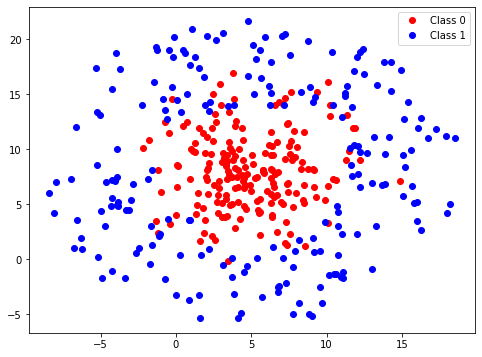

In [2]:
# Synthetic data
m_= 200
mu = np.array([5,8])
sigma = np.array([[10,0],[0,10]])
X1 = np.random.multivariate_normal(mu,sigma,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 6 + np.random.uniform(0,8,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)

plt.figure(figsize=(8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label = 'Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label = 'Class 1')
plt.legend()
plt.show()

**Kernel**


- Linear Kernel: 

$$\mathcal k(x,x^{'}) = x_{1}x_{1}^{'}+x_{2}x_{2}^{'}+...+x_{n}x_{n}^{'}$$
- Polynomial Kernel: 

$$\mathcal k(x,x^{'}) = x_{1}^{2}x_{1}^{'2}+x_{2}^{2}x_{2}^{'2}+...+x_{n}^{2}x_{n}^{'2}$$
- RBF Kernel (Radial Basis Function): 

$$\mathcal k(x,x^{'}) = \mathrm{e}^{\frac{-||x-x^{'}||^{2}}{2\sigma^{2}}} = e^{-\gamma||x-x^{'}||^{2}}$$

$$\gamma = \frac{1}{2\sigma^{2}}$$

$$K = \underbrace{\begin{vmatrix}K(x^{1},x^{1}) & K(x^{1},x^{2}) & .. & K(x^{1},x^{m}) \\K(x^{2},x^{1}) & K(x^{2},x^{2}) & .. & K(x^{2},x^{m})\\: & :& :\\K(x^{m},x^{1}) & K(x^{m},x^{2}) & .. & K(x^{m},x^{m})\end{vmatrix}}_{m \times m} $$


**SVMs model**

- Training set: The data are pairs $(\mathbf{x}^{(i)},y^{(i)})$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and $y^{(i)} \in \{-1,1\}$.

$$
2D: \mathbf{X} = \begin{vmatrix}x_{1}^{1} & x_{2}^{1} \\x_{1}^{2} & x_{2}^{2}\\: & :\\x_{1}^{m} & x_{2}^{m}\end{vmatrix} , \mathbf{y} = \begin{vmatrix} -1\\-1\\:\\1\end{vmatrix}
$$

- Structure of model:

$$h_{\mathbf{w},b}(\mathbf{x}) = \begin{cases} 1 & \text{if} \; \mathbf{w}^\top \mathbf{x} + b > 0 \\ -1 & \text{otherwise} \end{cases}$$

- Cost function:
$$\mathbf{w}^*,b^* = \mathrm{argmax}_{\mathbf{w},b} \gamma,$$

    where $\gamma$ is the minimum geometric margin for the training data:
    $$\gamma = \min_i \gamma^{(i)}$$
    
    and $\gamma^{(i)}$ is the geometric margin for training example $i$, i.e., the signed distance of $\mathbf{x}^{(i)}$ from the decision boundary,
  with positive distances indicating that the point is on the correct side of the boundary and negative distances indicating that the point is on the
  incorrect side of the boundary:
  $$\gamma^{(i)} = y^{(i)}\left( \left( \frac{\mathbf{w}}{\|\mathbf{w}\|} \right)^\top \mathbf{x}^{(i)} + \frac{b}{\| \mathbf{w}\|} \right). $$

- Optimal solution:

$$ \mathcal W(\alpha) = \min_{\alpha} \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}<x^{(i)},x^{(j)}> - \sum_{i=1}^{m}\alpha_{i} $$
$$\text{Such that: $-\alpha_{i} \le 0, i \in 1...m \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)} = 0 $}$$

$$
Q=y^{(i)}y^{(j)}\mathcal k(x,x^{'}) ; 
c = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{m \times 1} ; 
A = \underbrace{\begin{vmatrix}-1 & 0 & .. & 0 \\0 & -1 & .. & 0\\: & :& :\\0 & 0 & .. & -1\\1 & 0 & .. & 0 \\0 & 1 & .. & 0\\: & :& :\\0 & 0 & .. & 1\end{vmatrix}}_{2m \times m} ; 
b =\underbrace{\begin{vmatrix}0\\0 \\:\\0\\C\\C \\:\\C\end{vmatrix}}_{2m \times 1} ; 
E = \underbrace{\begin{vmatrix}y_{1} & y_{2} & .. & y_{m}\end{vmatrix}}_{1 \times m} ; d = 0
$$

**General Quadratic Programming**
$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$
- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

**Find b**:

$\mathcal S \small \text{ is the set of indexes of the support vectors: } \mathcal S = \{ i \in 1..m | \alpha_{i} > 0 \}; N_{\mathcal S} = len(\mathcal S)$

$$b =\frac{1}{N_{\mathcal S}}\sum_{i \in \mathcal S} \left(y^{(i)} - \sum_{j \in \mathcal S}\alpha_{j}y^{(j)} \mathcal k(x,x^{'}) \right)$$

In [3]:
# Training set
X = np.concatenate((X1,X2))
y = np.concatenate((-np.ones((X1.shape[0],1)),np.ones((X1.shape[0],1))))

In [4]:
# SVMs model RBF kernel with C
def rbf_kernel (X,sigma):
    m = X.shape[0]
    K = np.zeros((m,m))
    for i in range (m):
        for j in range (m):
            K[i,j] = (X[i,:]-X[j,:])@(X[i,:]-X[j,:])
    K = np.exp(-K/(2*sigma**2))
    return K

def set_param(X,y,sigma,C):
    m = X.shape[0]
    Q = (y@y.T)*rbf_kernel(X,sigma)
    c = - np.ones((m,1))
    A = np.concatenate((-np.eye((m)),np.eye((m))),0)
    b = np.concatenate((np.zeros((m,1)),np.ones((m,1))*C),0)
    E = y.T
    d = np.zeros((1,1))
    return Q, c, A, b, E, d

def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    args = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
    if E is not None:
        args.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(*args)
    return np.array(sol['x']).reshape(Q.shape[1])

def svms_fit(X,y,sigma,C):
    Q,c,A,b,E,d = set_param(X,y,sigma,C)
    opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)
    return opt_params 

def find_b (X,y,opt_params,sigma):
    S = np.where(opt_params>1e-5)[0] #[0] make S become a numpy array
    X_s = X[S,:]
    y_s = y[S]
    opt_params_s = opt_params[S].reshape(-1,1)
    b = (y_s - ((opt_params_s*y_s).T*rbf_kernel(X_s,sigma)).sum(axis=1,keepdims=True)).mean()
    print('Optimal Solution: b=',b)
    return b

def rbf_kernel_(x,xprime,sigma):
    return np.exp(-(x-xprime)@(x-xprime)/(2*sigma**2))

def predict (x,X,y,opt_params,b,sigma):
    results = np.zeros((x.shape[0],1))
    for i in range (x.shape[0]):
        results[i] = 0
        for j in range (X.shape[0]):
            results[i,0] += opt_params[j]*y[j,0]*rbf_kernel_(x[i,:],X[j,:],sigma)
        results[i] += b
    return np.sign(results)

def accuracy(X,y,opt_params,b,sigma):
    preds = predict(X,X,y,opt_params,b,sigma)
    acc = (preds == y).sum()/y.shape[0]
    return acc

In [5]:
rbf_sigma = 1
C = 1
#fit model
opt_params = svms_fit(X,y,sigma=rbf_sigma,C=C)

# find b, w
b = find_b(X,y,opt_params,sigma=rbf_sigma)

Optimal Solution: b= 0.4185932037958104


In [7]:
print('Training Accuracy:', accuracy(X,y,opt_params,b,sigma=rbf_sigma))

Training Accuracy: 0.945


**SVMs decision regions**:

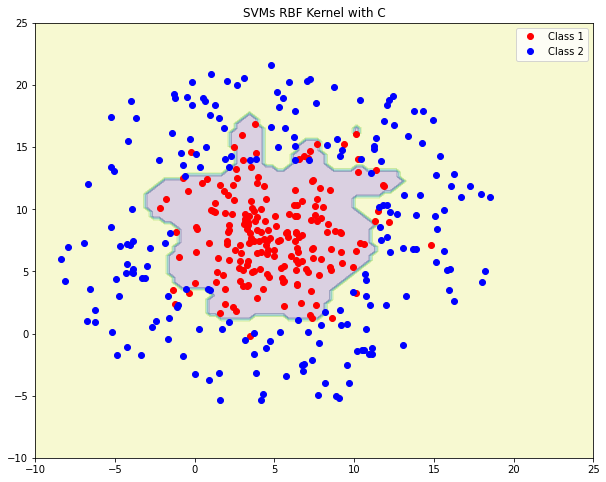

In [6]:
plt.figure(figsize=(10,8))
plt.plot(X[y.reshape(-1)==-1,0],X[y.reshape(-1)==-1,1],'ro',label='Class 1')
plt.plot(X[y.reshape(-1)==1,0],X[y.reshape(-1)==1,1],'bo',label='Class 2')

#color regions
grid_x,grid_y = np.mgrid[-10:25:100j,-10:25:100j]
grid_xy = np.vstack([grid_x.ravel(),grid_y.ravel()]).T
z = predict(grid_xy,X,y,opt_params,b,sigma=rbf_sigma).reshape((100,100))
plt.contourf(grid_x,grid_y,z,alpha = 0.2)
plt.title('SVMs RBF Kernel with C')
plt.legend()
plt.show()